#Import

In [4]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from sklearn import preprocessing
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model

tf.__version__

'1.14.0'

#Import Data

In [5]:
train_csv = pd.read_csv("https://raw.githubusercontent.com/First4196/landmark_recognition/resizer/liteData/ltrain.csv")
train_csv.rename(columns={'Unnamed: 0':'image'}, inplace=True)
print(train_csv.to_numpy())

[[0
  'https://upload.wikimedia.org/wikipedia/commons/6/6c/YR_Fossils_after_the_Storm_%2822039098589%29.jpg'
  0]
 [1
  'https://upload.wikimedia.org/wikipedia/commons/4/48/YR_An_Altered_Marsh_March_%2825882209990%29.jpg'
  0]
 [2
  'https://upload.wikimedia.org/wikipedia/commons/9/98/Steph_and_Brad_paddling_demo_%287165832382%29.jpg'
  0]
 ...
 [8137
  'https://upload.wikimedia.org/wikipedia/commons/5/58/A_View_from_the_Port_of_Tel_Aviv.jpg'
  99]
 [8138
  'https://upload.wikimedia.org/wikipedia/commons/e/e2/%D7%A0%D7%9E%D7%9C_%D7%AA%D7%9C_%D7%90%D7%91%D7%99%D7%91_8.JPG'
  99]
 [8139
  'https://upload.wikimedia.org/wikipedia/commons/f/f7/%D7%94%D7%A9%D7%AA%D7%A7%D7%A4%D7%95%D7%AA_%D7%94%D7%A0%D7%92%D7%A8_%D7%91%D7%A0%D7%9E%D7%9C_%D7%AA%22%D7%90.jpg'
  99]]


#Process Data

In [6]:
#C:\Users\Warit\OneDrive\เดสก์ท็อป\Pattern\resized\resized
img = Image.open('C:/Users/Warit/OneDrive/เดสก์ท็อป/Pattern/resized/resized/1.jpg')
pix = img.load()
print(img.size)

(320, 240)


In [7]:
from keras.preprocessing.image import img_to_array, load_img

def read_data(size, source, label, data_dir='C:/Users/Warit/OneDrive/เดสก์ท็อป/Pattern/resized/resized/'):
    features = np.array([], dtype=np.float32).reshape(0,size,size,3)
    for m in tqdm(range(source.shape[0])):
        filename = str(source[m]) + '.jpg'
        try:
            img = Image.open(data_dir + filename)
        except:
            label = np.delete(label, m, 0)
            continue
        img = img.resize((size, size))
        features_temp = img_to_array(img).reshape(1, size, size, 3)
        features = np.concatenate((features, features_temp), axis=0)

    return features, label

Using TensorFlow backend.


In [8]:
classes = 100
size = 224

x_train = np.array([])
y_train = np.array([])
x_val = np.array([])
y_val = np.array([])
x_test = np.array([])
y_test = np.array([])
for i in range(classes):
    temp = train_csv[train_csv['label'] == i].to_numpy()
    np.random.shuffle(temp)
    num_train = int(0.6*temp.shape[0])
    num_validate = int(0.2*temp.shape[0])
    num_test = temp.shape[0] - num_train - num_validate
  # x_train = temp[:num_train,0]
    x_train = np.concatenate((x_train,temp[:num_train,0]))
  # y_train = temp[:num_train,2]
    y_train = np.concatenate((y_train,temp[:num_train,2]))
    
  # x_val = temp[num_train:num_train+num_validate,0]
    x_val = np.concatenate((x_val,temp[num_train:num_train+num_validate,0]))
  # y_val = temp[num_train:num_train+num_validate,2]
    y_val = np.concatenate((y_val,temp[num_train:num_train+num_validate,2]))
    
    
  # x_test = temp[num_train+num_validate:,0]
    x_test = np.concatenate((x_test,temp[num_train+num_validate:,0]))
  # y_test = temp[num_train+num_validate:,2]
    y_test = np.concatenate((y_test,temp[num_train+num_validate:,2]))

In [9]:
x_val, y_val  = read_data(size, x_val, y_val)

100%|███████████████████████████████████████████████████████████████████████| 1584/1584 [04:23<00:00,  3.25it/s]


In [10]:
x_train, y_train = read_data(size, x_train, y_train)

100%|███████████████████████████████████████████████████████████████████████| 4845/4845 [37:54<00:00,  1.19it/s]


In [11]:
x_test, y_test  = read_data(size, x_test, y_test)

100%|███████████████████████████████████████████████████████████████████████| 1711/1711 [04:44<00:00,  3.18it/s]


In [12]:
# Fixed for our landmark dataset
NUM_CLASSES = 100
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
#OBJECTIVE_FUNCTION = 'categorical_crossentropy'

OBJECTIVE_FUNCTION = 'categorical_crossentropy'
# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [37]:
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

model = Sequential()
model.add(VGG19(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Dense(100, activation = DENSE_LAYER_ACTIVATION))

#model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

In [38]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_21 (Dense)             (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________


In [43]:
from tensorflow.python.keras import optimizers

#sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = 'sgd', loss = "sparse_categorical_crossentropy", metrics = LOSS_METRICS)

In [ ]:
from tensorflow.python.keras.utils.data_utils import Sequence
fit_history = model.fit(x_train, y_train,batch_size  = 1,
        epochs = 10,
        validation_data=(x_val,y_val),
        
)
#model.load_weights(base_directory + "/weight/best.hdf5")

Train on 4831 samples, validate on 1581 samples
Epoch 1/10


 197/4831 [>.............................] - ETA: 1:20:14 - loss: 10.8216 - acc: 0.0000e+0 - ETA: 1:10:39 - loss: 176484453.4108 - acc: 0.0000e+ - ETA: 1:06:24 - loss: nan - acc: 0.0000e+00           - ETA: 1:04:35 - loss: nan - acc: 0.0000e+0 - ETA: 1:03:31 - loss: nan - acc: 0.0000e+0 - ETA: 1:03:22 - loss: nan - acc: 0.0000e+0 - ETA: 1:03:01 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:49 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:32 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:15 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:09 - loss: nan - acc: 0.0000e+0 - ETA: 1:01:53 - loss: nan - acc: 0.0000e+0 - ETA: 1:01:39 - loss: nan - acc: 0.0000e+0 - ETA: 1:01:33 - loss: nan - acc: 0.0000e+0 - ETA: 1:01:49 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:07 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:19 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:22 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:41 - loss: nan - acc: 0.0000e+0 - ETA: 1:02:54 - loss: nan - acc: 0.0000e+0 - ETA: 1:03:02 - loss: nan - acc: 0.0000e+0 - ETA: 1

 401/4831 [=>............................] - ETA: 1:07:46 - loss: nan - acc: 0.035 - ETA: 1:07:48 - loss: nan - acc: 0.035 - ETA: 1:07:48 - loss: nan - acc: 0.035 - ETA: 1:07:48 - loss: nan - acc: 0.034 - ETA: 1:07:49 - loss: nan - acc: 0.034 - ETA: 1:07:48 - loss: nan - acc: 0.034 - ETA: 1:07:50 - loss: nan - acc: 0.039 - ETA: 1:07:49 - loss: nan - acc: 0.039 - ETA: 1:07:49 - loss: nan - acc: 0.038 - ETA: 1:07:48 - loss: nan - acc: 0.038 - ETA: 1:07:48 - loss: nan - acc: 0.038 - ETA: 1:07:48 - loss: nan - acc: 0.038 - ETA: 1:07:51 - loss: nan - acc: 0.038 - ETA: 1:07:50 - loss: nan - acc: 0.037 - ETA: 1:07:49 - loss: nan - acc: 0.037 - ETA: 1:07:49 - loss: nan - acc: 0.037 - ETA: 1:07:50 - loss: nan - acc: 0.037 - ETA: 1:07:49 - loss: nan - acc: 0.037 - ETA: 1:07:48 - loss: nan - acc: 0.037 - ETA: 1:07:50 - loss: nan - acc: 0.036 - ETA: 1:07:49 - loss: nan - acc: 0.036 - ETA: 1:07:48 - loss: nan - acc: 0.036 - ETA: 1:07:48 - loss: nan - acc: 0.036 - ETA: 1:07:47 - loss: nan - acc: 0.0

 605/4831 [==>...........................] - ETA: 1:06:39 - loss: nan - acc: 0.032 - ETA: 1:06:38 - loss: nan - acc: 0.032 - ETA: 1:06:39 - loss: nan - acc: 0.032 - ETA: 1:06:38 - loss: nan - acc: 0.032 - ETA: 1:06:37 - loss: nan - acc: 0.032 - ETA: 1:06:36 - loss: nan - acc: 0.031 - ETA: 1:06:35 - loss: nan - acc: 0.034 - ETA: 1:06:35 - loss: nan - acc: 0.034 - ETA: 1:06:35 - loss: nan - acc: 0.036 - ETA: 1:06:34 - loss: nan - acc: 0.036 - ETA: 1:06:33 - loss: nan - acc: 0.036 - ETA: 1:06:32 - loss: nan - acc: 0.036 - ETA: 1:06:31 - loss: nan - acc: 0.036 - ETA: 1:06:31 - loss: nan - acc: 0.036 - ETA: 1:06:30 - loss: nan - acc: 0.036 - ETA: 1:06:29 - loss: nan - acc: 0.036 - ETA: 1:06:28 - loss: nan - acc: 0.035 - ETA: 1:06:27 - loss: nan - acc: 0.035 - ETA: 1:06:26 - loss: nan - acc: 0.035 - ETA: 1:06:26 - loss: nan - acc: 0.035 - ETA: 1:06:25 - loss: nan - acc: 0.035 - ETA: 1:06:24 - loss: nan - acc: 0.035 - ETA: 1:06:23 - loss: nan - acc: 0.035 - ETA: 1:06:22 - loss: nan - acc: 0.0

 809/4831 [====>.........................] - ETA: 1:04:09 - loss: nan - acc: 0.028 - ETA: 1:04:07 - loss: nan - acc: 0.029 - ETA: 1:04:06 - loss: nan - acc: 0.029 - ETA: 1:04:05 - loss: nan - acc: 0.029 - ETA: 1:04:04 - loss: nan - acc: 0.029 - ETA: 1:04:03 - loss: nan - acc: 0.029 - ETA: 1:04:02 - loss: nan - acc: 0.029 - ETA: 1:04:01 - loss: nan - acc: 0.029 - ETA: 1:04:00 - loss: nan - acc: 0.029 - ETA: 1:03:59 - loss: nan - acc: 0.029 - ETA: 1:03:59 - loss: nan - acc: 0.029 - ETA: 1:03:58 - loss: nan - acc: 0.029 - ETA: 1:03:57 - loss: nan - acc: 0.029 - ETA: 1:03:56 - loss: nan - acc: 0.029 - ETA: 1:03:55 - loss: nan - acc: 0.029 - ETA: 1:03:55 - loss: nan - acc: 0.029 - ETA: 1:03:54 - loss: nan - acc: 0.028 - ETA: 1:03:53 - loss: nan - acc: 0.028 - ETA: 1:03:53 - loss: nan - acc: 0.028 - ETA: 1:03:52 - loss: nan - acc: 0.028 - ETA: 1:03:51 - loss: nan - acc: 0.028 - ETA: 1:03:50 - loss: nan - acc: 0.028 - ETA: 1:03:49 - loss: nan - acc: 0.028 - ETA: 1:03:48 - loss: nan - acc: 0.0

1019/4831 [=====>........................] - ETA: 1:01:13 - loss: nan - acc: 0.030 - ETA: 1:01:11 - loss: nan - acc: 0.030 - ETA: 1:01:10 - loss: nan - acc: 0.030 - ETA: 1:01:09 - loss: nan - acc: 0.030 - ETA: 1:01:08 - loss: nan - acc: 0.030 - ETA: 1:01:07 - loss: nan - acc: 0.030 - ETA: 1:01:07 - loss: nan - acc: 0.030 - ETA: 1:01:06 - loss: nan - acc: 0.030 - ETA: 1:01:05 - loss: nan - acc: 0.030 - ETA: 1:01:03 - loss: nan - acc: 0.030 - ETA: 1:01:02 - loss: nan - acc: 0.030 - ETA: 1:01:02 - loss: nan - acc: 0.030 - ETA: 1:01:01 - loss: nan - acc: 0.030 - ETA: 1:01:01 - loss: nan - acc: 0.031 - ETA: 1:01:00 - loss: nan - acc: 0.031 - ETA: 1:00:59 - loss: nan - acc: 0.031 - ETA: 1:00:59 - loss: nan - acc: 0.031 - ETA: 1:00:59 - loss: nan - acc: 0.031 - ETA: 1:00:58 - loss: nan - acc: 0.031 - ETA: 1:00:57 - loss: nan - acc: 0.031 - ETA: 1:00:56 - loss: nan - acc: 0.031 - ETA: 1:00:54 - loss: nan - acc: 0.031 - ETA: 1:00:53 - loss: nan - acc: 0.031 - ETA: 1:00:52 - loss: nan - acc: 0.0

1234/4831 [======>.......................] - ETA: 58:03 - loss: nan - acc: 0.031 - ETA: 58:02 - loss: nan - acc: 0.031 - ETA: 58:01 - loss: nan - acc: 0.031 - ETA: 58:01 - loss: nan - acc: 0.031 - ETA: 58:00 - loss: nan - acc: 0.031 - ETA: 57:59 - loss: nan - acc: 0.031 - ETA: 57:58 - loss: nan - acc: 0.031 - ETA: 57:57 - loss: nan - acc: 0.031 - ETA: 57:56 - loss: nan - acc: 0.031 - ETA: 57:55 - loss: nan - acc: 0.031 - ETA: 57:54 - loss: nan - acc: 0.031 - ETA: 57:54 - loss: nan - acc: 0.031 - ETA: 57:53 - loss: nan - acc: 0.031 - ETA: 57:52 - loss: nan - acc: 0.031 - ETA: 57:51 - loss: nan - acc: 0.030 - ETA: 57:50 - loss: nan - acc: 0.030 - ETA: 57:49 - loss: nan - acc: 0.030 - ETA: 57:48 - loss: nan - acc: 0.030 - ETA: 57:47 - loss: nan - acc: 0.030 - ETA: 57:46 - loss: nan - acc: 0.030 - ETA: 57:45 - loss: nan - acc: 0.030 - ETA: 57:44 - loss: nan - acc: 0.030 - ETA: 57:43 - loss: nan - acc: 0.030 - ETA: 57:42 - loss: nan - acc: 0.030 - ETA: 57:41 - loss: nan - acc: 0.030 - ETA: 

1449/4831 [=======>......................] - ETA: 54:45 - loss: nan - acc: 0.029 - ETA: 54:45 - loss: nan - acc: 0.029 - ETA: 54:44 - loss: nan - acc: 0.029 - ETA: 54:44 - loss: nan - acc: 0.029 - ETA: 54:43 - loss: nan - acc: 0.029 - ETA: 54:42 - loss: nan - acc: 0.029 - ETA: 54:41 - loss: nan - acc: 0.029 - ETA: 54:40 - loss: nan - acc: 0.029 - ETA: 54:39 - loss: nan - acc: 0.029 - ETA: 54:38 - loss: nan - acc: 0.029 - ETA: 54:37 - loss: nan - acc: 0.029 - ETA: 54:36 - loss: nan - acc: 0.029 - ETA: 54:36 - loss: nan - acc: 0.029 - ETA: 54:36 - loss: nan - acc: 0.029 - ETA: 54:36 - loss: nan - acc: 0.029 - ETA: 54:35 - loss: nan - acc: 0.029 - ETA: 54:34 - loss: nan - acc: 0.029 - ETA: 54:33 - loss: nan - acc: 0.029 - ETA: 54:33 - loss: nan - acc: 0.029 - ETA: 54:32 - loss: nan - acc: 0.030 - ETA: 54:31 - loss: nan - acc: 0.030 - ETA: 54:31 - loss: nan - acc: 0.030 - ETA: 54:30 - loss: nan - acc: 0.031 - ETA: 54:30 - loss: nan - acc: 0.031 - ETA: 54:29 - loss: nan - acc: 0.031 - ETA: 

1664/4831 [=========>....................] - ETA: 51:42 - loss: nan - acc: 0.030 - ETA: 51:41 - loss: nan - acc: 0.030 - ETA: 51:40 - loss: nan - acc: 0.030 - ETA: 51:39 - loss: nan - acc: 0.030 - ETA: 51:38 - loss: nan - acc: 0.030 - ETA: 51:37 - loss: nan - acc: 0.030 - ETA: 51:36 - loss: nan - acc: 0.030 - ETA: 51:35 - loss: nan - acc: 0.030 - ETA: 51:34 - loss: nan - acc: 0.030 - ETA: 51:33 - loss: nan - acc: 0.030 - ETA: 51:32 - loss: nan - acc: 0.030 - ETA: 51:31 - loss: nan - acc: 0.030 - ETA: 51:30 - loss: nan - acc: 0.030 - ETA: 51:29 - loss: nan - acc: 0.030 - ETA: 51:28 - loss: nan - acc: 0.030 - ETA: 51:27 - loss: nan - acc: 0.030 - ETA: 51:26 - loss: nan - acc: 0.030 - ETA: 51:25 - loss: nan - acc: 0.030 - ETA: 51:24 - loss: nan - acc: 0.030 - ETA: 51:23 - loss: nan - acc: 0.030 - ETA: 51:22 - loss: nan - acc: 0.029 - ETA: 51:21 - loss: nan - acc: 0.029 - ETA: 51:21 - loss: nan - acc: 0.030 - ETA: 51:20 - loss: nan - acc: 0.030 - ETA: 51:19 - loss: nan - acc: 0.030 - ETA: 

1879/4831 [==========>...................] - ETA: 48:18 - loss: nan - acc: 0.030 - ETA: 48:17 - loss: nan - acc: 0.030 - ETA: 48:17 - loss: nan - acc: 0.030 - ETA: 48:16 - loss: nan - acc: 0.030 - ETA: 48:15 - loss: nan - acc: 0.030 - ETA: 48:14 - loss: nan - acc: 0.030 - ETA: 48:13 - loss: nan - acc: 0.031 - ETA: 48:12 - loss: nan - acc: 0.031 - ETA: 48:11 - loss: nan - acc: 0.031 - ETA: 48:10 - loss: nan - acc: 0.031 - ETA: 48:09 - loss: nan - acc: 0.031 - ETA: 48:09 - loss: nan - acc: 0.031 - ETA: 48:08 - loss: nan - acc: 0.031 - ETA: 48:07 - loss: nan - acc: 0.031 - ETA: 48:06 - loss: nan - acc: 0.031 - ETA: 48:05 - loss: nan - acc: 0.031 - ETA: 48:04 - loss: nan - acc: 0.030 - ETA: 48:03 - loss: nan - acc: 0.030 - ETA: 48:02 - loss: nan - acc: 0.030 - ETA: 48:01 - loss: nan - acc: 0.030 - ETA: 48:00 - loss: nan - acc: 0.030 - ETA: 47:59 - loss: nan - acc: 0.030 - ETA: 47:58 - loss: nan - acc: 0.030 - ETA: 47:57 - loss: nan - acc: 0.030 - ETA: 47:57 - loss: nan - acc: 0.030 - ETA: 

2094/4831 [============>.................] - ETA: 45:06 - loss: nan - acc: 0.031 - ETA: 45:05 - loss: nan - acc: 0.031 - ETA: 45:04 - loss: nan - acc: 0.031 - ETA: 45:03 - loss: nan - acc: 0.031 - ETA: 45:02 - loss: nan - acc: 0.031 - ETA: 45:01 - loss: nan - acc: 0.031 - ETA: 45:00 - loss: nan - acc: 0.031 - ETA: 44:59 - loss: nan - acc: 0.032 - ETA: 44:58 - loss: nan - acc: 0.032 - ETA: 44:57 - loss: nan - acc: 0.032 - ETA: 44:56 - loss: nan - acc: 0.032 - ETA: 44:55 - loss: nan - acc: 0.032 - ETA: 44:54 - loss: nan - acc: 0.032 - ETA: 44:54 - loss: nan - acc: 0.032 - ETA: 44:53 - loss: nan - acc: 0.032 - ETA: 44:52 - loss: nan - acc: 0.032 - ETA: 44:51 - loss: nan - acc: 0.032 - ETA: 44:50 - loss: nan - acc: 0.032 - ETA: 44:49 - loss: nan - acc: 0.032 - ETA: 44:48 - loss: nan - acc: 0.032 - ETA: 44:47 - loss: nan - acc: 0.032 - ETA: 44:46 - loss: nan - acc: 0.032 - ETA: 44:45 - loss: nan - acc: 0.032 - ETA: 44:44 - loss: nan - acc: 0.032 - ETA: 44:43 - loss: nan - acc: 0.032 - ETA: 

2309/4831 [=============>................] - ETA: 41:51 - loss: nan - acc: 0.033 - ETA: 41:50 - loss: nan - acc: 0.033 - ETA: 41:49 - loss: nan - acc: 0.033 - ETA: 41:48 - loss: nan - acc: 0.033 - ETA: 41:47 - loss: nan - acc: 0.033 - ETA: 41:46 - loss: nan - acc: 0.033 - ETA: 41:45 - loss: nan - acc: 0.033 - ETA: 41:44 - loss: nan - acc: 0.033 - ETA: 41:43 - loss: nan - acc: 0.033 - ETA: 41:42 - loss: nan - acc: 0.033 - ETA: 41:41 - loss: nan - acc: 0.033 - ETA: 41:40 - loss: nan - acc: 0.033 - ETA: 41:40 - loss: nan - acc: 0.033 - ETA: 41:39 - loss: nan - acc: 0.033 - ETA: 41:38 - loss: nan - acc: 0.033 - ETA: 41:37 - loss: nan - acc: 0.033 - ETA: 41:36 - loss: nan - acc: 0.033 - ETA: 41:35 - loss: nan - acc: 0.033 - ETA: 41:34 - loss: nan - acc: 0.033 - ETA: 41:33 - loss: nan - acc: 0.033 - ETA: 41:32 - loss: nan - acc: 0.033 - ETA: 41:31 - loss: nan - acc: 0.033 - ETA: 41:30 - loss: nan - acc: 0.033 - ETA: 41:29 - loss: nan - acc: 0.033 - ETA: 41:28 - loss: nan - acc: 0.033 - ETA: 

2524/4831 [==============>...............] - ETA: 38:34 - loss: nan - acc: 0.033 - ETA: 38:33 - loss: nan - acc: 0.033 - ETA: 38:32 - loss: nan - acc: 0.033 - ETA: 38:31 - loss: nan - acc: 0.033 - ETA: 38:30 - loss: nan - acc: 0.033 - ETA: 38:29 - loss: nan - acc: 0.033 - ETA: 38:28 - loss: nan - acc: 0.033 - ETA: 38:28 - loss: nan - acc: 0.033 - ETA: 38:27 - loss: nan - acc: 0.033 - ETA: 38:26 - loss: nan - acc: 0.033 - ETA: 38:25 - loss: nan - acc: 0.033 - ETA: 38:24 - loss: nan - acc: 0.033 - ETA: 38:23 - loss: nan - acc: 0.033 - ETA: 38:22 - loss: nan - acc: 0.033 - ETA: 38:21 - loss: nan - acc: 0.033 - ETA: 38:20 - loss: nan - acc: 0.033 - ETA: 38:19 - loss: nan - acc: 0.033 - ETA: 38:18 - loss: nan - acc: 0.033 - ETA: 38:17 - loss: nan - acc: 0.033 - ETA: 38:16 - loss: nan - acc: 0.033 - ETA: 38:15 - loss: nan - acc: 0.033 - ETA: 38:14 - loss: nan - acc: 0.033 - ETA: 38:13 - loss: nan - acc: 0.033 - ETA: 38:12 - loss: nan - acc: 0.033 - ETA: 38:12 - loss: nan - acc: 0.033 - ETA: 

2739/4831 [================>.............] - ETA: 35:19 - loss: nan - acc: 0.030 - ETA: 35:18 - loss: nan - acc: 0.030 - ETA: 35:17 - loss: nan - acc: 0.030 - ETA: 35:16 - loss: nan - acc: 0.030 - ETA: 35:15 - loss: nan - acc: 0.030 - ETA: 35:14 - loss: nan - acc: 0.030 - ETA: 35:13 - loss: nan - acc: 0.030 - ETA: 35:12 - loss: nan - acc: 0.030 - ETA: 35:11 - loss: nan - acc: 0.030 - ETA: 35:10 - loss: nan - acc: 0.030 - ETA: 35:09 - loss: nan - acc: 0.030 - ETA: 35:09 - loss: nan - acc: 0.030 - ETA: 35:08 - loss: nan - acc: 0.030 - ETA: 35:07 - loss: nan - acc: 0.030 - ETA: 35:06 - loss: nan - acc: 0.030 - ETA: 35:05 - loss: nan - acc: 0.030 - ETA: 35:04 - loss: nan - acc: 0.030 - ETA: 35:03 - loss: nan - acc: 0.030 - ETA: 35:02 - loss: nan - acc: 0.030 - ETA: 35:01 - loss: nan - acc: 0.030 - ETA: 35:00 - loss: nan - acc: 0.030 - ETA: 34:59 - loss: nan - acc: 0.030 - ETA: 34:58 - loss: nan - acc: 0.030 - ETA: 34:57 - loss: nan - acc: 0.030 - ETA: 34:56 - loss: nan - acc: 0.030 - ETA: 

2954/4831 [=================>............] - ETA: 32:02 - loss: nan - acc: 0.031 - ETA: 32:01 - loss: nan - acc: 0.031 - ETA: 32:00 - loss: nan - acc: 0.031 - ETA: 31:59 - loss: nan - acc: 0.031 - ETA: 31:58 - loss: nan - acc: 0.031 - ETA: 31:57 - loss: nan - acc: 0.031 - ETA: 31:56 - loss: nan - acc: 0.031 - ETA: 31:55 - loss: nan - acc: 0.030 - ETA: 31:54 - loss: nan - acc: 0.030 - ETA: 31:53 - loss: nan - acc: 0.030 - ETA: 31:52 - loss: nan - acc: 0.030 - ETA: 31:52 - loss: nan - acc: 0.030 - ETA: 31:51 - loss: nan - acc: 0.030 - ETA: 31:50 - loss: nan - acc: 0.030 - ETA: 31:49 - loss: nan - acc: 0.030 - ETA: 31:48 - loss: nan - acc: 0.030 - ETA: 31:47 - loss: nan - acc: 0.030 - ETA: 31:46 - loss: nan - acc: 0.030 - ETA: 31:45 - loss: nan - acc: 0.030 - ETA: 31:44 - loss: nan - acc: 0.030 - ETA: 31:43 - loss: nan - acc: 0.030 - ETA: 31:42 - loss: nan - acc: 0.030 - ETA: 31:41 - loss: nan - acc: 0.030 - ETA: 31:40 - loss: nan - acc: 0.030 - ETA: 31:39 - loss: nan - acc: 0.030 - ETA: 

3169/4831 [==================>...........] - ETA: 28:43 - loss: nan - acc: 0.030 - ETA: 28:43 - loss: nan - acc: 0.030 - ETA: 28:42 - loss: nan - acc: 0.030 - ETA: 28:41 - loss: nan - acc: 0.030 - ETA: 28:40 - loss: nan - acc: 0.030 - ETA: 28:39 - loss: nan - acc: 0.030 - ETA: 28:38 - loss: nan - acc: 0.030 - ETA: 28:37 - loss: nan - acc: 0.030 - ETA: 28:36 - loss: nan - acc: 0.030 - ETA: 28:35 - loss: nan - acc: 0.030 - ETA: 28:34 - loss: nan - acc: 0.030 - ETA: 28:33 - loss: nan - acc: 0.030 - ETA: 28:32 - loss: nan - acc: 0.030 - ETA: 28:31 - loss: nan - acc: 0.030 - ETA: 28:30 - loss: nan - acc: 0.030 - ETA: 28:29 - loss: nan - acc: 0.030 - ETA: 28:29 - loss: nan - acc: 0.031 - ETA: 28:28 - loss: nan - acc: 0.031 - ETA: 28:27 - loss: nan - acc: 0.030 - ETA: 28:26 - loss: nan - acc: 0.030 - ETA: 28:25 - loss: nan - acc: 0.030 - ETA: 28:24 - loss: nan - acc: 0.030 - ETA: 28:23 - loss: nan - acc: 0.030 - ETA: 28:22 - loss: nan - acc: 0.030 - ETA: 28:21 - loss: nan - acc: 0.030 - ETA: 

3384/4831 [====================>.........] - ETA: 25:27 - loss: nan - acc: 0.030 - ETA: 25:26 - loss: nan - acc: 0.030 - ETA: 25:25 - loss: nan - acc: 0.030 - ETA: 25:24 - loss: nan - acc: 0.030 - ETA: 25:23 - loss: nan - acc: 0.030 - ETA: 25:22 - loss: nan - acc: 0.030 - ETA: 25:21 - loss: nan - acc: 0.030 - ETA: 25:20 - loss: nan - acc: 0.030 - ETA: 25:19 - loss: nan - acc: 0.030 - ETA: 25:19 - loss: nan - acc: 0.030 - ETA: 25:18 - loss: nan - acc: 0.030 - ETA: 25:17 - loss: nan - acc: 0.030 - ETA: 25:16 - loss: nan - acc: 0.030 - ETA: 25:15 - loss: nan - acc: 0.030 - ETA: 25:14 - loss: nan - acc: 0.030 - ETA: 25:13 - loss: nan - acc: 0.030 - ETA: 25:12 - loss: nan - acc: 0.030 - ETA: 25:11 - loss: nan - acc: 0.030 - ETA: 25:10 - loss: nan - acc: 0.030 - ETA: 25:09 - loss: nan - acc: 0.030 - ETA: 25:08 - loss: nan - acc: 0.030 - ETA: 25:07 - loss: nan - acc: 0.030 - ETA: 25:06 - loss: nan - acc: 0.030 - ETA: 25:05 - loss: nan - acc: 0.030 - ETA: 25:05 - loss: nan - acc: 0.030 - ETA: 

3599/4831 [=====================>........] - ETA: 22:09 - loss: nan - acc: 0.030 - ETA: 22:08 - loss: nan - acc: 0.031 - ETA: 22:07 - loss: nan - acc: 0.031 - ETA: 22:07 - loss: nan - acc: 0.031 - ETA: 22:06 - loss: nan - acc: 0.031 - ETA: 22:05 - loss: nan - acc: 0.031 - ETA: 22:04 - loss: nan - acc: 0.031 - ETA: 22:03 - loss: nan - acc: 0.031 - ETA: 22:02 - loss: nan - acc: 0.031 - ETA: 22:01 - loss: nan - acc: 0.031 - ETA: 22:00 - loss: nan - acc: 0.031 - ETA: 21:59 - loss: nan - acc: 0.031 - ETA: 21:58 - loss: nan - acc: 0.031 - ETA: 21:57 - loss: nan - acc: 0.031 - ETA: 21:56 - loss: nan - acc: 0.031 - ETA: 21:56 - loss: nan - acc: 0.031 - ETA: 21:55 - loss: nan - acc: 0.031 - ETA: 21:54 - loss: nan - acc: 0.031 - ETA: 21:53 - loss: nan - acc: 0.031 - ETA: 21:52 - loss: nan - acc: 0.031 - ETA: 21:51 - loss: nan - acc: 0.031 - ETA: 21:50 - loss: nan - acc: 0.031 - ETA: 21:49 - loss: nan - acc: 0.031 - ETA: 21:48 - loss: nan - acc: 0.031 - ETA: 21:47 - loss: nan - acc: 0.031 - ETA: 

3814/4831 [======================>.......] - ETA: 18:55 - loss: nan - acc: 0.031 - ETA: 18:54 - loss: nan - acc: 0.031 - ETA: 18:53 - loss: nan - acc: 0.031 - ETA: 18:52 - loss: nan - acc: 0.031 - ETA: 18:52 - loss: nan - acc: 0.031 - ETA: 18:51 - loss: nan - acc: 0.031 - ETA: 18:50 - loss: nan - acc: 0.031 - ETA: 18:49 - loss: nan - acc: 0.031 - ETA: 18:48 - loss: nan - acc: 0.031 - ETA: 18:47 - loss: nan - acc: 0.031 - ETA: 18:46 - loss: nan - acc: 0.031 - ETA: 18:45 - loss: nan - acc: 0.031 - ETA: 18:44 - loss: nan - acc: 0.031 - ETA: 18:43 - loss: nan - acc: 0.031 - ETA: 18:42 - loss: nan - acc: 0.031 - ETA: 18:41 - loss: nan - acc: 0.031 - ETA: 18:40 - loss: nan - acc: 0.031 - ETA: 18:39 - loss: nan - acc: 0.031 - ETA: 18:38 - loss: nan - acc: 0.031 - ETA: 18:38 - loss: nan - acc: 0.031 - ETA: 18:37 - loss: nan - acc: 0.031 - ETA: 18:36 - loss: nan - acc: 0.031 - ETA: 18:35 - loss: nan - acc: 0.031 - ETA: 18:34 - loss: nan - acc: 0.031 - ETA: 18:33 - loss: nan - acc: 0.031 - ETA: 

4029/4831 [========================>.....] - ETA: 15:37 - loss: nan - acc: 0.032 - ETA: 15:36 - loss: nan - acc: 0.032 - ETA: 15:35 - loss: nan - acc: 0.032 - ETA: 15:34 - loss: nan - acc: 0.032 - ETA: 15:33 - loss: nan - acc: 0.032 - ETA: 15:32 - loss: nan - acc: 0.032 - ETA: 15:31 - loss: nan - acc: 0.032 - ETA: 15:30 - loss: nan - acc: 0.032 - ETA: 15:29 - loss: nan - acc: 0.032 - ETA: 15:28 - loss: nan - acc: 0.032 - ETA: 15:27 - loss: nan - acc: 0.032 - ETA: 15:26 - loss: nan - acc: 0.032 - ETA: 15:25 - loss: nan - acc: 0.032 - ETA: 15:25 - loss: nan - acc: 0.032 - ETA: 15:24 - loss: nan - acc: 0.032 - ETA: 15:23 - loss: nan - acc: 0.032 - ETA: 15:22 - loss: nan - acc: 0.032 - ETA: 15:21 - loss: nan - acc: 0.032 - ETA: 15:20 - loss: nan - acc: 0.032 - ETA: 15:19 - loss: nan - acc: 0.032 - ETA: 15:18 - loss: nan - acc: 0.032 - ETA: 15:17 - loss: nan - acc: 0.032 - ETA: 15:16 - loss: nan - acc: 0.032 - ETA: 15:15 - loss: nan - acc: 0.032 - ETA: 15:14 - loss: nan - acc: 0.032 - ETA: 

4155/4831 [========================>.....] - ETA: 12:19 - loss: nan - acc: 0.031 - ETA: 12:18 - loss: nan - acc: 0.031 - ETA: 12:17 - loss: nan - acc: 0.031 - ETA: 12:16 - loss: nan - acc: 0.031 - ETA: 12:15 - loss: nan - acc: 0.031 - ETA: 12:14 - loss: nan - acc: 0.031 - ETA: 12:13 - loss: nan - acc: 0.031 - ETA: 12:12 - loss: nan - acc: 0.031 - ETA: 12:11 - loss: nan - acc: 0.031 - ETA: 12:10 - loss: nan - acc: 0.030 - ETA: 12:09 - loss: nan - acc: 0.030 - ETA: 12:08 - loss: nan - acc: 0.030 - ETA: 12:07 - loss: nan - acc: 0.030 - ETA: 12:07 - loss: nan - acc: 0.030 - ETA: 12:06 - loss: nan - acc: 0.030 - ETA: 12:05 - loss: nan - acc: 0.030 - ETA: 12:04 - loss: nan - acc: 0.030 - ETA: 12:03 - loss: nan - acc: 0.030 - ETA: 12:02 - loss: nan - acc: 0.030 - ETA: 12:01 - loss: nan - acc: 0.030 - ETA: 12:00 - loss: nan - acc: 0.030 - ETA: 11:59 - loss: nan - acc: 0.030 - ETA: 11:58 - loss: nan - acc: 0.030 - ETA: 11:57 - loss: nan - acc: 0.030 - ETA: 11:56 - loss: nan - acc: 0.030 - ETA: 

In [24]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


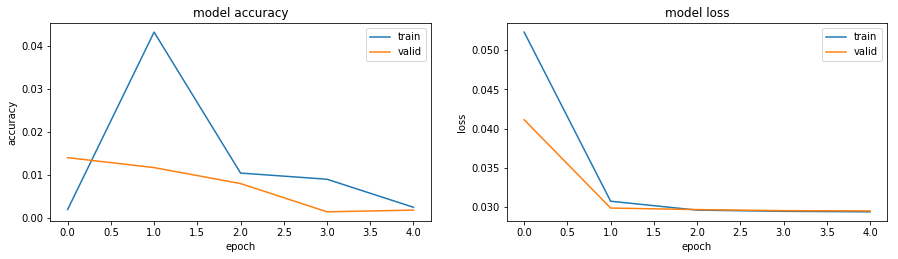

In [32]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()